In [12]:
from experiments.evaluation_flow.shared import MODELS
from experiments.plots.util import *

In [13]:
all_files_parsed = parse_all_log_files('/Users/nils/Downloads/log-dir')
baseline_only = filter_parsed_files(all_files_parsed, ('approach', 'baseline'))
baseline_versions = filter_parsed_files(baseline_only, ('snapshot_type', 'version'))
baseline_version_food = filter_parsed_files(baseline_versions, ('snapshot_dist', 'food'))

baseline_version_food_server = filter_parsed_files(baseline_version_food, ('location', 'server'))
baseline_version_food_server_0 = filter_parsed_files(baseline_version_food_server, ('run', '0'))

baseline_version_food_node = filter_parsed_files(baseline_version_food, ('location', 'node'))
baseline_version_food_node_0 = filter_parsed_files(baseline_version_food_node, ('run', '1'))

save_times = {}

for file in baseline_version_food_server_0:
    meta, events = file
    times = {}
    for e in events:
        if e.use_case == U_1:
            times[U_1] = e.duration_s
        elif e.use_case == U_2:
            times[U_2] = e.duration_s
    save_times[meta[MODEL]] = times

for file in baseline_version_food_node_0:
    meta, events = file
    times = {}
    u31_counter = 1
    u32_counter = 1
    for e in events:
        if e.use_case and e.use_case.startswith(U_3_1):
            key = "{}_{}".format(e.use_case, u31_counter)
            times[key] = e.duration_s
            u31_counter += 1
        elif e.use_case and e.use_case.startswith(U_3_2):
            key = "{}_{}".format(e.use_case, u32_counter)
            times[key] = e.duration_s
            u32_counter += 1
    save_times[meta[MODEL]].update(times)

file is broken: /Users/nils/Downloads/log-dir/server--model:googlenet--approach:param_update_improved--snapshot_type:version--snapshot_dist:food--run:0.txt


In [14]:
print(save_times)

{'resnet152': {'U_1': 12.787701155, 'U_2': 2.7725080120000003, 'U_3_1_1_1': 2.6951335170000004, 'U_3_1_2_2': 2.927743672, 'U_3_1_3_3': 2.8929273340000004, 'U_3_1_4_4': 2.9447655420000003, 'U_3_2_1_1': 3.0245889900000003, 'U_3_2_2_2': 3.055462422, 'U_3_2_3_3': 3.237782832, 'U_3_2_4_4': 3.194681457}, 'mobilenet': {'U_1': 11.76404119, 'U_2': 1.691511478, 'U_3_1_1_1': 1.6623781260000001, 'U_3_1_2_2': 1.6708560060000002, 'U_3_1_3_3': 1.682609108, 'U_3_1_4_4': 1.719956284, 'U_3_2_1_1': 1.7585348710000002, 'U_3_2_2_2': 1.7696120270000002, 'U_3_2_3_3': 1.7732378100000001, 'U_3_2_4_4': 1.753987605}, 'resnet50': {'U_1': 12.185344464, 'U_2': 2.096717371, 'U_3_1_1_1': 2.07856303, 'U_3_1_2_2': 2.137121619, 'U_3_1_3_3': 2.221249798, 'U_3_1_4_4': 2.280966434, 'U_3_2_1_1': 2.356307644, 'U_3_2_2_2': 2.395022134, 'U_3_2_3_3': 2.375022334, 'U_3_2_4_4': 2.433422391}, 'googlenet': {'U_1': 11.877562383, 'U_2': 1.8627877890000002, 'U_3_1_1_1': 1.826154483, 'U_3_1_2_2': 1.8127797550000002, 'U_3_1_3_3': 1.8002

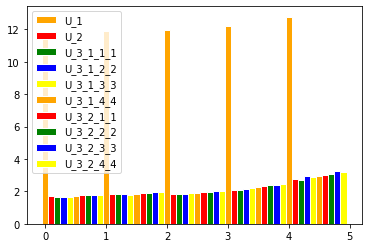

In [25]:
import numpy as np
import matplotlib.pyplot as plt

# set width of bars
barWidth = 0.1

bars = {}
for m in MODELS:
    times = save_times[m]
    for use_case, time in times.items():
        if use_case in bars:
            bars[use_case].append(time)
        else:
            bars[use_case] = [time]

# Set position of bar on X axis
# l = len(bars[U_1])
# print(l)
# positions = [np.arange(l)]
# for i in range(1, len(bars)):
#     prev_positions = positions[-1]
#     positions.append(prev_positions)

r1 = np.arange(5)
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]
r5 = [x + barWidth for x in r4]
r6 = [x + barWidth for x in r5]
r7 = [x + barWidth for x in r6]
r8 = [x + barWidth for x in r7]
r9 = [x + barWidth for x in r8]
r10 = [x + barWidth for x in r9]
positions = [r1, r2, r3, r4, r5, r6, r7, r8, r9, r10]

colors = ['orange', 'red', 'green', 'blue', 'yellow', 'orange', 'red', 'green', 'blue', 'yellow']

for position, bar, color, label in zip(positions, bars.values(), colors, bars.keys()):
    plt.bar(position, bar, color=color, width=barWidth, edgecolor='white', label=label)

# # Add xticks on the middle of the group bars
# plt.xlabel('group', fontweight='bold')
# plt.xticks([r + barWidth for r in range(len(bars1))], ['A', 'B', 'C', 'D', 'E'])

# Create legend & Show graphic
plt.legend()
plt.show()